# Data Quality Visualizations

In [ ]:
import time
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import contextily as cx

# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state"

## Station-wise flag rates

In [ ]:
network_flag_path = f"s3://{BUCKET_NAME}/{MERGE_DIR}/ASOSAWOS/eraqc_counts_native_timestep/ASOSAWOS_A0705300346_flag_counts_native_timestep.csv"
flag_df_1_hello = pd.read_csv(network_flag_path)

In [ ]:
network_flag_path_2 = f"s3://{BUCKET_NAME}/{MERGE_DIR}/ASOSAWOS/eraqc_counts_native_timestep/ASOSAWOS_A0685400115_flag_counts_native_timestep.csv"
flag_df_2_hello = pd.read_csv(network_flag_path_2)

In [ ]:
flag_df_1_hello

In [ ]:
flag_df_2_hello

In [ ]:
flag_df_1 = flag_df_1_hello.set_index("eraqc_flag_values")
subset = flag_df_1[~flag_df_1.index.isin(["no_flag", "total_obs_count"])]

totals = subset.sum(numeric_only=True)
flag_df_1.loc["total_flag"] = pd.Series(totals)

frac = flag_df_1.loc["total_flag"] / flag_df_1.loc["total_obs_count"]
flag_df_1.loc["frac"] = pd.Series(frac)

rates_df = flag_df_1.loc[["frac"]]
rates_df = rates_df.rename(index={"frac": 'station_name'})

In [ ]:
flag_df_2 = flag_df_2_hello.set_index("eraqc_flag_values")
subset_2 = flag_df_2[~flag_df_2.index.isin(["no_flag", "total_obs_count"])]

totals = subset_2.sum(numeric_only=True)
flag_df_2.loc["total_flag"] = pd.Series(totals)

frac_2= flag_df_2.loc["total_flag"] / flag_df_2.loc["total_obs_count"]
flag_df_2.loc["frac"] = pd.Series(frac_2)

rates_df_2 = flag_df_2.loc[["frac"]]
rates_df_2 = rates_df_2.rename(index={"frac": "station_name_2"})

In [ ]:
rates_df = rates_df.reset_index()

In [ ]:
rates_df

In [ ]:
rates_df_2 = rates_df_2.reset_index()

In [ ]:
rates_df_2

In [ ]:
test = pd.merge(rates_df,rates_df_2, how='outer')

In [ ]:
test

In [ ]:
network_flag_path_3 = f"s3://{BUCKET_NAME}/{MERGE_DIR}/ASOSAWOS/eraqc_counts_native_timestep/ASOSAWOS_99999994176_flag_counts_native_timestep.csv"
flag_df_3_hello = pd.read_csv(network_flag_path_3)

In [ ]:
station_name = network_flag_path.split(f"s3://{BUCKET_NAME}/{MERGE_DIR}/ASOSAWOS/eraqc_counts_native_timestep" + "/")[1]

In [ ]:
station_name

In [ ]:
total_obs = rates_df_2[flag_df_1_hello['eraqc_flag_values']=='total_obs_count'].iloc[0,1]

In [ ]:
rates_df["total_obs_count"] = total_obs

In [ ]:
rates_df

In [ ]:
def _pairwise_rate(flag_df_1: pd.DataFrame, flag_df_2: pd.DataFrame,station_name: str) -> pd.DataFrame:
    """
    Sums two input flag count dataframes. This is a helper function for sum_flag_counts().

    Parameters
    ----------
    flag_df_1: pd.DataFrame
        dataframe of previously summed station flag counts
    flag_df_2: pd.DataFrame
        flag counts dataframes for next station

    Returns
    -------
    summed_df: pd.DataFrame

    """
    flag_df_1 = flag_df_1.set_index("eraqc_flag_values")
    subset = flag_df_1[~flag_df_1.index.isin(["no_flag", "total_obs_count"])]

    totals = subset.sum(numeric_only=True)
    flag_df_1.loc["total_flag"] = pd.Series(totals)

    frac = flag_df_1.loc["total_flag"] / flag_df_1.loc["total_obs_count"]
    flag_df_1.loc["frac"] = pd.Series(frac)

    rates_df = flag_df_1.loc[["frac"]]
    rates_df = rates_df.rename(index={"frac": station_name})

    rates_df = rates_df.reset_index()

    # append column of total observation count
    flag_df_1 = flag_df_1.reset_index()
    total_obs = flag_df_1[flag_df_1['eraqc_flag_values']=='total_obs_count'].iloc[0,1]
    rates_df['total_obs_count'] = total_obs

    if len(flag_df_2) == 0:
        return rates_df

    else:
        rates_df_merge = pd.merge(rates_df, flag_df_2, how="outer")
        return rates_df_merge

In [ ]:
network = "VCAPCD"

vectorization, column-wise computation

include "total counts" column, counts for each station (can be referenced later)

use append for the station-wise rate tables
merge (?) for network-wise rate tables -> will take care of this for you
- if use append, would need to be exlicit about how to handle new columns (tell it to fill with NAs) -> perhaps more control

=> using merge for a single row should not be necessary

2D data may not be sufficient anymore
- we'll have x num of different variable names


include station type in map (buoy vs land (airport, mountain, etc.)) -> point shape


go with sparse dataframe, with total counts included (ie merge)


color = flag rate
point size = total obs count

In [ ]:
# the function iteratively adds in flag counts to this dataframe
flag_rate_df = []

# point to folder containing station flag count CSVs
flags_prefix = f"{MERGE_DIR}/{network}/eraqc_counts_native_timestep"  # /per_network_flag_counts_native_timestep/"

## Merge flag counts

# loop through all CSVs are the given level
for item in s3.Bucket(BUCKET_NAME).objects.filter(Prefix=flags_prefix):
    obj = s3_cl.get_object(Bucket=BUCKET_NAME, Key=item.key)
    flags = pd.read_csv(obj["Body"])
    station_name = item.key.split(flags_prefix + "/")[1].split("_flag")[0]
    # the CSV is empty
    if flags.empty:
        continue
    # the CSV is not empty
    else:
        # send current dataframe and dataframe of previously summed counts to helper function
        flag_rate_df = _pairwise_rate(flags, flag_rate_df,station_name)
# print(station_name)

In [ ]:
flag_rate_df = flag_rate_df.rename(columns={"eraqc_flag_values": "era-id"})

In [ ]:
flag_rate_df = flag_rate_df.drop("elevation", axis=1)

In [113]:
flag_rate_df

,era-id,hurs,pr_1h,rsds,sfcWind_dir,sfcWind,tas,tdps_derived,total_obs_count,ps,pr
0,VCAPCD_TO,0.001498,0.000279,0.001347,0.002822,0.001486,0.003403,0.009395,86112.0,NaN,NaN
1,VCAPCD_SV,0.001683,0.000000,0.000856,0.002733,0.001537,0.001780,0.007226,102822.0,0.000311,NaN
2,VCAPCD_SU,0.002337,0.000000,0.002046,0.003850,0.002308,0.004024,0.009144,103124.0,0.001435,0.0
3,VCAPCD_PU,0.001378,0.000000,0.001227,0.001644,0.001355,0.000706,0.006322,86368.0,NaN,NaN
4,VCAPCD_OJ,0.000908,0.000232,0.008078,0.001314,0.000908,0.000502,0.003614,103492.0,NaN,0.0
5,VCAPCD_ER,0.001669,0.000000,0.000621,0.006269,0.000767,0.002271,0.006871,103040.0,0.000049,0.0


### Merge with station list

In [ ]:
station_list = pd.read_csv(stations_csv_path)
sub_station_list = station_list[station_list['network']==network]

In [ ]:
sub_station_list

In [107]:
merged_list = sub_station_list.merge(flag_rate_df, on="era-id")

In [110]:
merged_list

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network,...,hurs,pr_1h,rsds,sfcWind_dir,sfcWind,tas,tdps_derived,total_obs_count,ps,pr
0,15874,VCAPCD_TO,34.21014,-118.87050,810.0,2012-10-05 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.001498,0.000279,0.001347,0.002822,0.001486,0.003403,0.009395,86112.0,NaN,NaN
1,15875,VCAPCD_SV,34.27640,-118.68375,1037.0,2010-05-27 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.001683,0.000000,0.000856,0.002733,0.001537,0.001780,0.007226,102822.0,0.000311,NaN
2,15876,VCAPCD_SU,34.29124,-118.79761,945.0,2010-05-27 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.002337,0.000000,0.002046,0.003850,0.002308,0.004024,0.009144,103124.0,0.001435,0.0
3,15877,VCAPCD_ER,34.25238,-119.14318,131.0,2010-05-27 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.001669,0.000000,0.000621,0.006269,0.000767,0.002271,0.006871,103040.0,0.000049,0.0
4,15878,VCAPCD_OJ,34.44804,-119.23131,774.0,2010-05-27 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.000908,0.000232,0.008078,0.001314,0.000908,0.000502,0.003614,103492.0,NaN,0.0
5,15879,VCAPCD_PU,34.40426,-118.80991,636.0,2012-10-04 00:00:00+00:00,2023-03-08 20:00:00+00:00,Y,2023-03-21 21:39:51+00:00,VCAPCD,...,0.001378,0.000000,0.001227,0.001644,0.001355,0.000706,0.006322,86368.0,NaN,NaN


next steps: extract station name

## Network-wise flag rates

In [ ]:
network_flag_path_ = f"s3://{BUCKET_NAME}/{MERGE_DIR}/per_network_flag_counts_native_timestep/VCAPCD_flag_counts_native_timestep.csv"
flag_df = pd.read_csv(network_flag_path)

In [ ]:
flag_df

## Map

In [112]:
map_list = merged_list

# Format dates in datetime format (this gets lost in import).
map_list["start-date"] = pd.to_datetime(map_list["start-date"], utc=True)
map_list["end-date"] = pd.to_datetime(map_list["end-date"], utc=True)

# Make a geodataframe.
gdf = gpd.GeoDataFrame(
    map_list,
    geometry=gpd.points_from_xy(map_list.longitude, map_list.latitude),
)
gdf.set_crs(epsg=4326, inplace=True)  # Set CRS

# Project data to match base tiles.
gdf_wm = gdf.to_crs(epsg=3857)  # Web mercator

# Read in geometry of continental US.
us = gpd.read_file(shapepath)

# Remove territories, AK, HI
rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
us = us.loc[us.STUSPS.isin(rem_list) == False]

# Use to clip stations
us = us.to_crs(epsg=3857)
gdf_us = gdf_wm.clip(us)



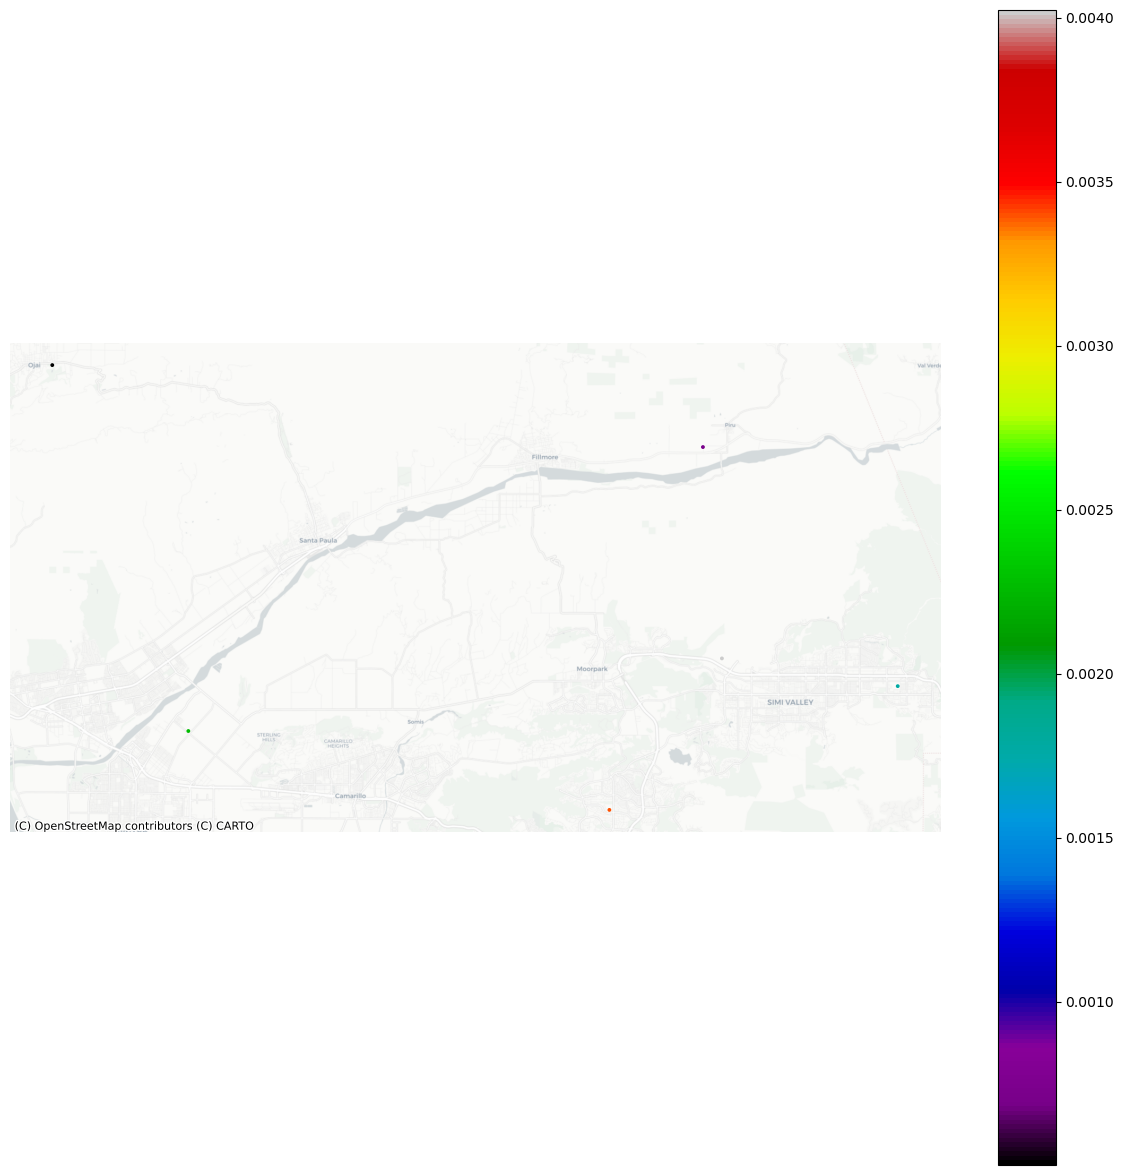

In [114]:
# Plot
ax = gdf_us.plot(
    "tas",
    figsize=(15, 15),
    alpha=1,
    markersize=3,
    legend=True,
    cmap="nipy_spectral",
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()